In [18]:
# Importing Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from wordcloud import WordCloud
from collections import Counter
import numpy as np

# Set global seaborn style for consistency
sns.set(style="whitegrid")

### --- Step 1: Data Loading ---

# Load Datasets
lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')
news_data = pd.read_csv('/Users/m1/Downloads/data/VHF/EWS/news_article.csv')
tweets_data = pd.read_csv('/Users/m1/Downloads/data/VHF/EWS/tweets.csv')
population_data = pd.read_csv('/Users/m1/Downloads/data/VHF/populationdata.csv')

### --- Step 2: Data Inspection and Basic Checks ---
# Inspect the datasets for structure and missing values

# Lassa Fever Data
print("Lassa Fever Data Info:")
print(lassa_fever_data.info())
print("Lassa Fever Missing Values:\n", lassa_fever_data.isnull().sum())

# Climatic Data
print("Climatic Data Info:")
print(climatic_data.info())
print("Climatic Data Missing Values:\n", climatic_data.isnull().sum())

# Mobility Data
print("Mobility Data Info:")
print(mobility_data.info())
print("Mobility Data Missing Values:\n", mobility_data.isnull().sum())

# News Data
print("News Data Info:")
print(news_data.info())
print("News Data Missing Values:\n", news_data.isnull().sum())

# Tweets Data
print("Tweets Data Info:")
print(tweets_data.info())
print("Tweets Data Missing Values:\n", tweets_data.isnull().sum())

### --- Step 3: Data Preprocessing ---

# Rename columns for consistency
lassa_fever_data.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data.rename(columns={'sub_region_1': 'state'}, inplace=True)
news_data.rename(columns={'date published': 'date'}, inplace=True)
tweets_data.rename(columns={'Created_At': 'date'}, inplace=True)

# Convert the date columns to datetime format
lassa_fever_data['date'] = pd.to_datetime(lassa_fever_data['date'], errors='coerce')
climatic_data['date'] = pd.to_datetime(climatic_data['date'], format='%Y%m%d', errors='coerce')
mobility_data['date'] = pd.to_datetime(mobility_data['date'], format='%d/%m/%Y', errors='coerce')
tweets_data['date'] = pd.to_datetime(tweets_data['date'], errors='coerce', format='%a %b %d %H:%M:%S %z %Y').dt.tz_localize(None)
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce', format='%d/%m/%Y %H:%M')

# Handle missing values in Lassa Fever Data: Treat each column as appropriate
for col in lassa_fever_data.columns:
    if lassa_fever_data[col].dtype == 'category':
        # Fill missing values in categorical columns with the most frequent value (mode)
        lassa_fever_data[col].fillna(lassa_fever_data[col].mode()[0], inplace=True)
    elif lassa_fever_data[col].dtype in ['int64', 'float64']:
        # Fill missing values in numerical columns with 0
        lassa_fever_data[col].fillna(0, inplace=True)
    else:
        # For any other column types, treat as empty string or appropriate method
        lassa_fever_data[col].fillna('', inplace=True)

# Handle missing values in Climatic Data: Use forward fill
climatic_data.fillna(method='ffill', inplace=True)

# Handle missing values in Mobility Data: Use the mean
for col in mobility_data.select_dtypes(include=['int64', 'float64']).columns:
    mobility_data[col].fillna(mobility_data[col].mean(), inplace=True)

# Handle missing values in textual data (news and tweets)
news_data.fillna('', inplace=True)  # Treat missing text as empty strings
tweets_data.fillna('', inplace=True)


Lassa Fever Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20062 entries, 0 to 20061
Data columns (total 99 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   DID                                             20062 non-null  object  
 1   Disease                                         20062 non-null  object  
 2   Pregnancy                                       20062 non-null  object  
 3   DateofdischargeortransferMdyyyy                 1019 non-null   object  
 4   DateofdeathMdyyyy                               637 non-null    object  
 5   Symptomatic                                     20062 non-null  object  
 6   InitialSampleFinalLaboratoryResultPathogentest  20062 non-null  object  
 7   LatestSampleDate                                1287 non-null   object  
 8   LatestSampleFinalLaboratoryResultPathogentest   20062 non-null  object  
 9   date_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193018 entries, 0 to 193017
Data columns (total 15 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   country_region_code                                 193018 non-null  object 
 1   country_region                                      193018 non-null  object 
 2   sub_region_1                                        192044 non-null  object 
 3   sub_region_2                                        156347 non-null  object 
 4   metro_area                                          0 non-null       float64
 5   iso_3166_2_code                                     35697 non-null   object 
 6   census_fips_code                                    0 non-null       float64
 7   place_id                                            193018 non-null  object 
 8   date                                                193018 non-n

Lassa Fever Descriptive Statistics:
        date_of_report_years      sex_new2  length_stay_hospital  \
count          20062.000000  20062.000000          20062.000000   
mean            2019.748829      1.498455              0.428322   
std                0.918582      0.535256              6.620637   
min             2018.000000      0.000000           -358.000000   
25%             2019.000000      1.000000              0.000000   
50%             2020.000000      2.000000              0.000000   
75%             2020.000000      2.000000              0.000000   
max             2021.000000      2.000000            405.000000   

       date_report_months  date_onset_months  
count        20062.000000       20062.000000  
mean             5.174609           4.234074  
std              3.656404           3.914321  
min              1.000000           0.000000  
25%              2.000000           1.000000  
50%              4.000000           3.000000  
75%              8.000000     

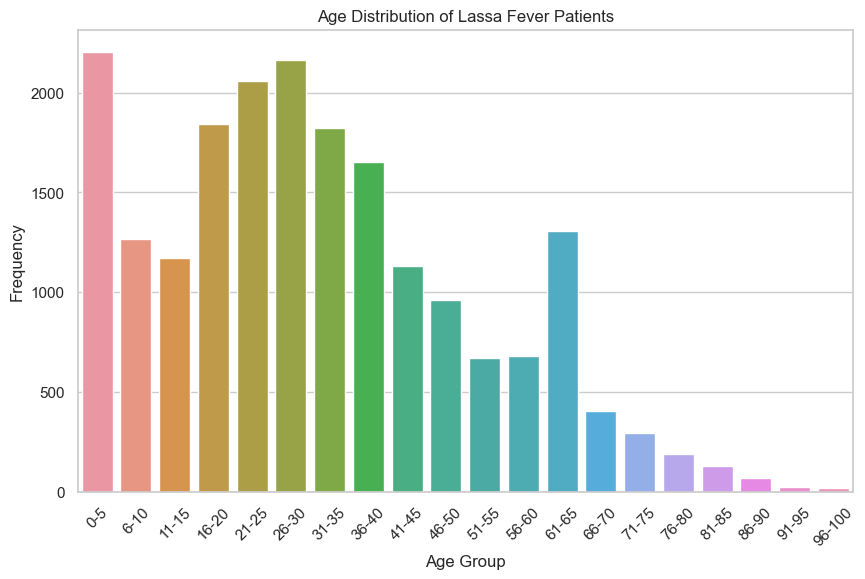

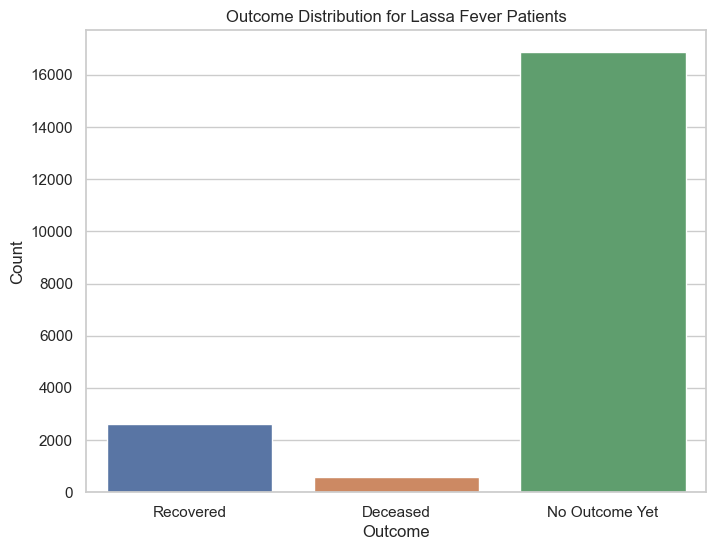

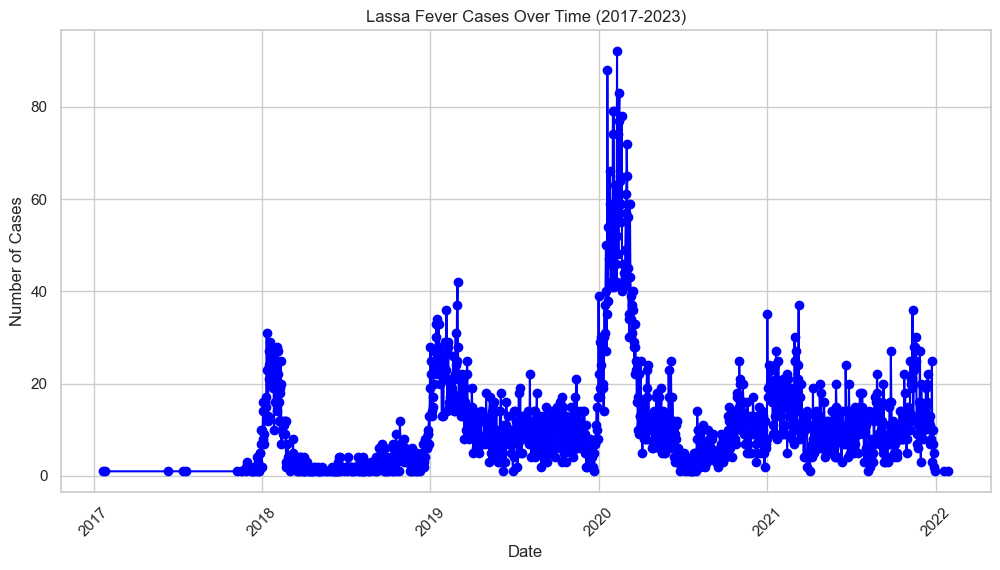

<Figure size 1000x1000 with 0 Axes>

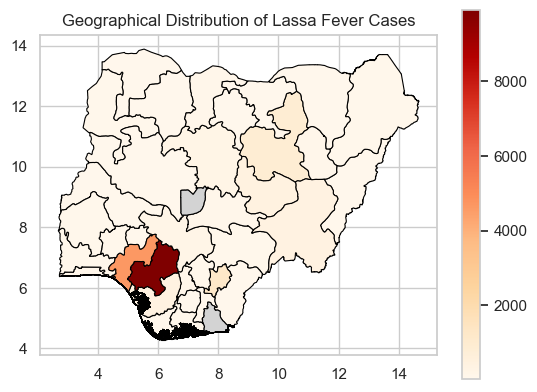

<Figure size 1000x1000 with 0 Axes>

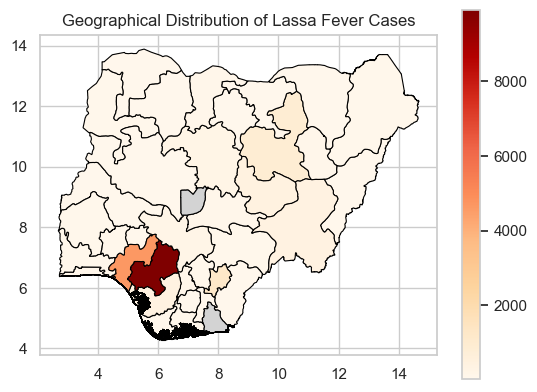

In [20]:
### --- Step 4: Descriptive Statistics and Distributions ---

# Generate basic descriptive statistics
print("Lassa Fever Descriptive Statistics:\n", lassa_fever_data.describe())
print("Climatic Data Descriptive Statistics:\n", climatic_data.describe())
print("Mobility Data Descriptive Statistics:\n", mobility_data.describe())

### --- Step 5: Lassa Fever Data Analysis ---

# Age Distribution of Lassa Fever Patients
# Step 1: Convert non-numeric values in 'age_recode' to NaN (handle invalid values)
lassa_fever_data['age_recode'] = pd.to_numeric(lassa_fever_data['age_recode'], errors='coerce')

# Step 2: Define the age bins and labels
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '81-85', '86-90', '91-95', '96-100']

# Step 3: Create a new column 'Age_group' using pd.cut()
lassa_fever_data['Age_group'] = pd.cut(lassa_fever_data['age_recode'], bins=bins, labels=labels, include_lowest=True)

# Step 4: Visualize the age distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Age_group', data=lassa_fever_data)
plt.title('Age Distribution of Lassa Fever Patients')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# Outcome Distribution (Recovered, Deceased, No Outcome Yet)
plt.figure(figsize=(8, 6))
sns.countplot(x='outcome_case', data=lassa_fever_data, order=['Recovered', 'Deceased', 'No Outcome Yet'])
plt.title('Outcome Distribution for Lassa Fever Patients')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

# Time-Series Analysis of Lassa Fever Cases Over Time (2017-2023)
filtered_data = lassa_fever_data[(lassa_fever_data['date'] >= '2017-01-01') & 
                                 (lassa_fever_data['date'] <= '2023-12-31')]

lassa_fever_time_series = filtered_data.groupby('date')['outcome_case'].count().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(lassa_fever_time_series['date'], lassa_fever_time_series['outcome_case'], marker='o', color='blue')
plt.title('Lassa Fever Cases Over Time (2017-2023)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### --- Step 6: Geospatial Analysis (Lassa Fever Cases) ---

# Load Nigeria shapefile for geographical analysis
gdf_nigeria = gpd.read_file('/Users/m1/Downloads/data/VHF/gadm41_NGA_shp/gadm41_NGA_1.shp')

# Merge Lassa Fever data with geographical shapefile based on state
gdf_merged = gdf_nigeria.merge(
    lassa_fever_data.groupby('state')['outcome_case'].count().reset_index(),
    left_on='NAME_1', 
    right_on='state', 
    how='left'
)

# Plotting the geographical distribution of Lassa Fever cases
plt.figure(figsize=(10, 10))
gdf_merged.plot(
    column='outcome_case', 
    cmap='OrRd', 
    legend=True, 
    missing_kwds={"color": "lightgrey"},
    edgecolor='black', 
    linewidth=0.8
)
plt.title('Geographical Distribution of Lassa Fever Cases')
plt.show()

# Group Lassa Fever cases by state
lassa_fever_geo = lassa_fever_data.groupby('state')['outcome_case'].count().reset_index()

# Merge with the geographical data (using shapefile of Nigeria regions)
gdf_merged = gdf_nigeria.merge(lassa_fever_geo, left_on='NAME_1', right_on='state', how='left')

# Plot the geographical distribution of total Lassa Fever cases
plt.figure(figsize=(10, 10))
gdf_merged.plot(
    column='outcome_case', 
    cmap='OrRd', 
    legend=True, 
    missing_kwds={"color": "lightgrey"},
    edgecolor='black', 
    linewidth=0.8
)
plt.title('Geographical Distribution of Lassa Fever Cases')
plt.show()

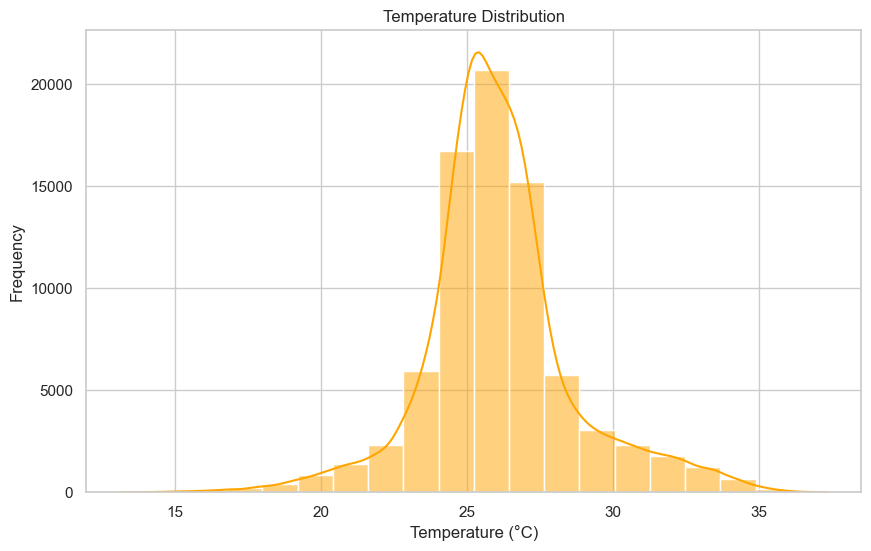

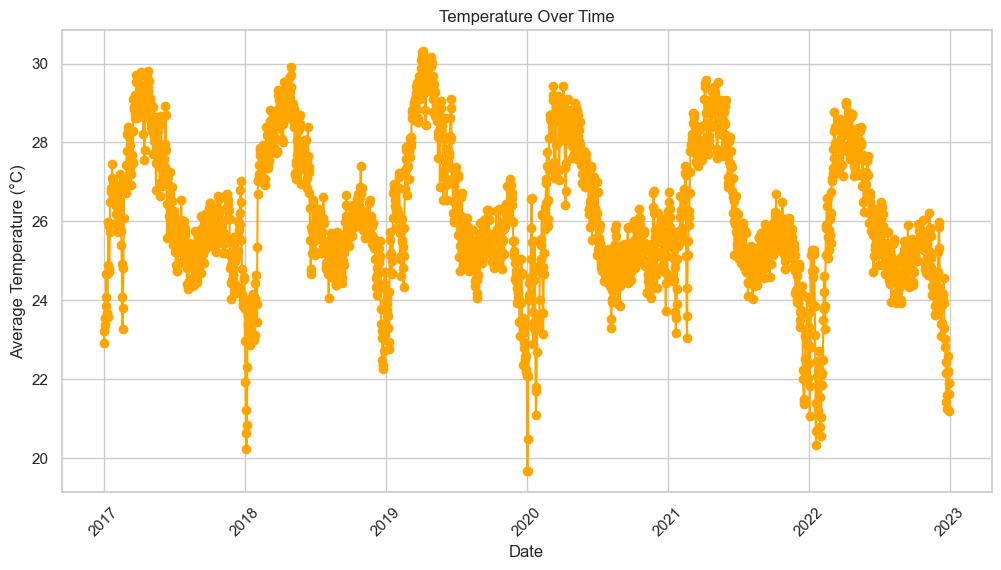

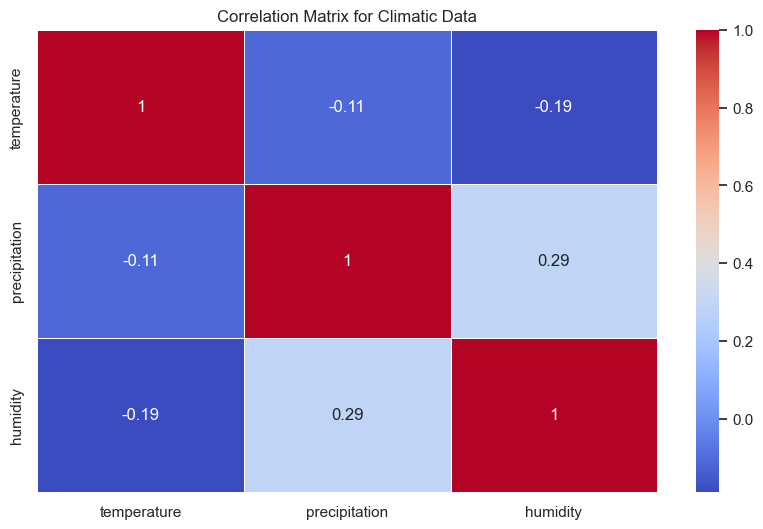

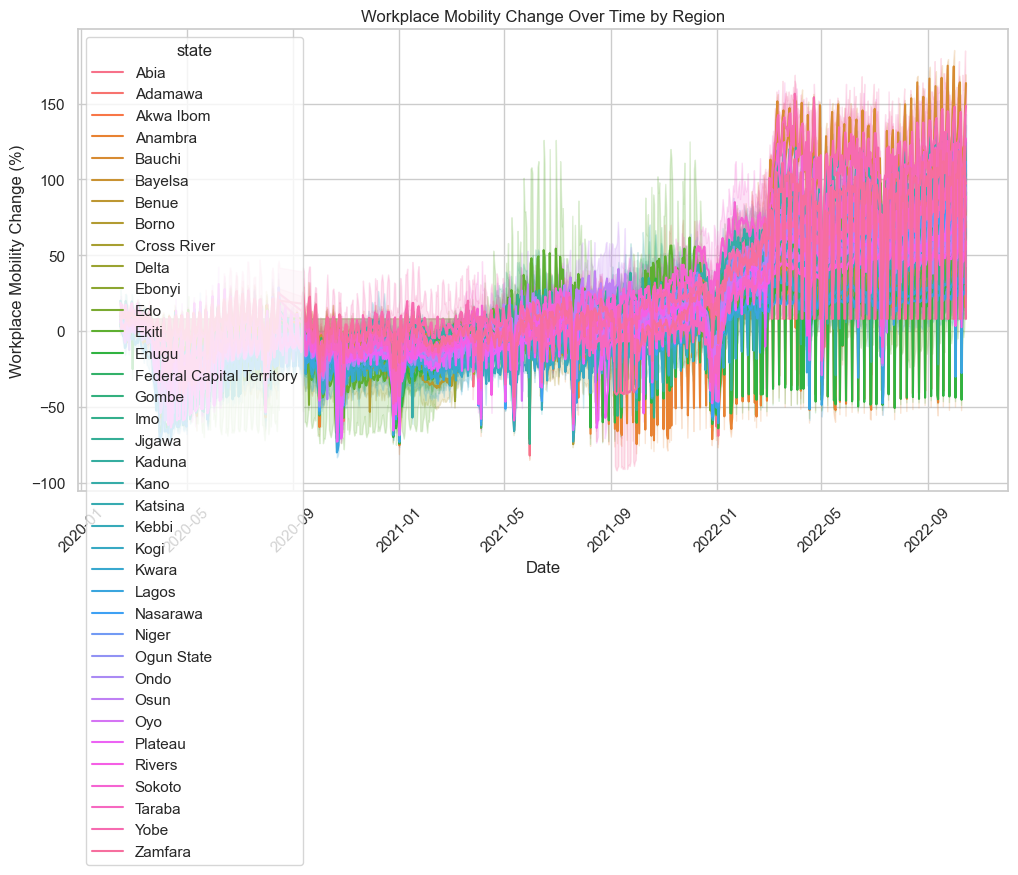

<Figure size 1000x1000 with 0 Axes>

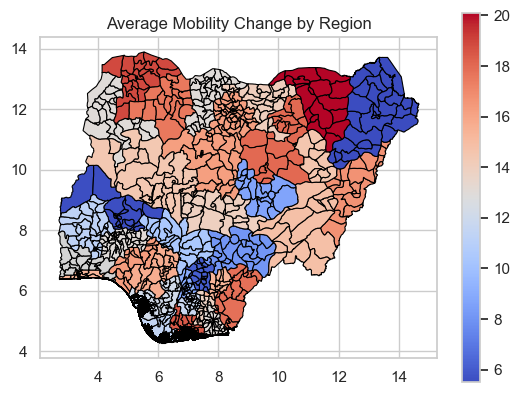

<Figure size 1000x1000 with 0 Axes>

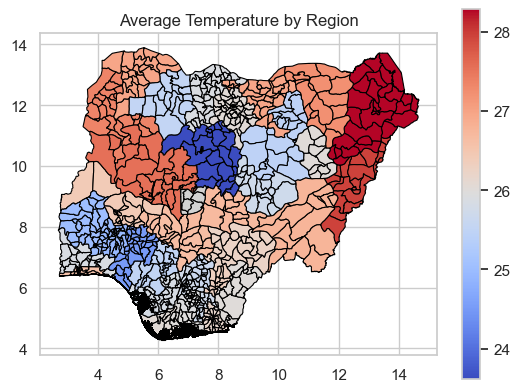

In [14]:
### --- Step 7: Climatic Data Analysis ---

# Plot temperature distribution
plt.figure(figsize=(10, 6))
sns.histplot(climatic_data['temperature'], bins=20, kde=True, color='orange')
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

# Time-Series Analysis: Temperature Over Time
climate_time_series = climatic_data.groupby('date')['temperature'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(climate_time_series['date'], climate_time_series['temperature'], marker='o', color='orange')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Correlation between temperature, humidity, and precipitation
plt.figure(figsize=(10, 6))
sns.heatmap(climatic_data[['temperature', 'precipitation', 'humidity']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Climatic Data')
plt.show()

### --- Step 8: Mobility Data Analysis ---

# Time-Series Plot for Workplace Mobility Change Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=mobility_data, x='date', y='workplaces_percent_change_from_baseline', hue='state')
plt.title('Workplace Mobility Change Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Workplace Mobility Change (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Calculate mean mobility changes across workplaces, transit, and residential areas
mobility_data['mean_mobility'] = mobility_data[['workplaces_percent_change_from_baseline', 
                                                'transit_stations_percent_change_from_baseline', 
                                                'residential_percent_change_from_baseline']].mean(axis=1)

# Group mobility data by state
mobility_geo = mobility_data.groupby('state')['mean_mobility'].mean().reset_index()

# Merge with the geographical data (using shapefile of Nigeria regions)
gdf_mobility = gdf_nigeria.merge(mobility_geo, left_on='NAME_1', right_on='state', how='left')

# Plot the geographical distribution of mobility changes
plt.figure(figsize=(10, 10))
gdf_mobility.plot(
    column='mean_mobility', 
    cmap='coolwarm', 
    legend=True, 
    missing_kwds={"color": "lightgrey"},
    edgecolor='black', 
    linewidth=0.8
)
plt.title('Average Mobility Change by Region')
plt.show()

# Group climatic data (e.g., temperature) by state
climate_geo = climatic_data.groupby('state')['temperature'].mean().reset_index()

# Merge climatic data with geographical shapefile based on state
gdf_climate = gdf_nigeria.merge(climate_geo, left_on='NAME_1', right_on='state', how='left')

# Plot temperature distribution across regions
plt.figure(figsize=(10, 10))
gdf_climate.plot(
    column='temperature', 
    cmap='coolwarm', 
    legend=True, 
    missing_kwds={"color": "lightgrey"},
    edgecolor='black', 
    linewidth=0.8
)
plt.title('Average Temperature by Region')
plt.show()

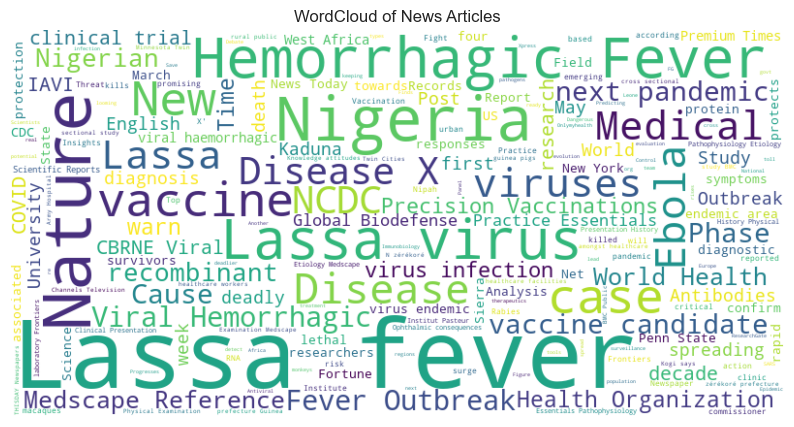

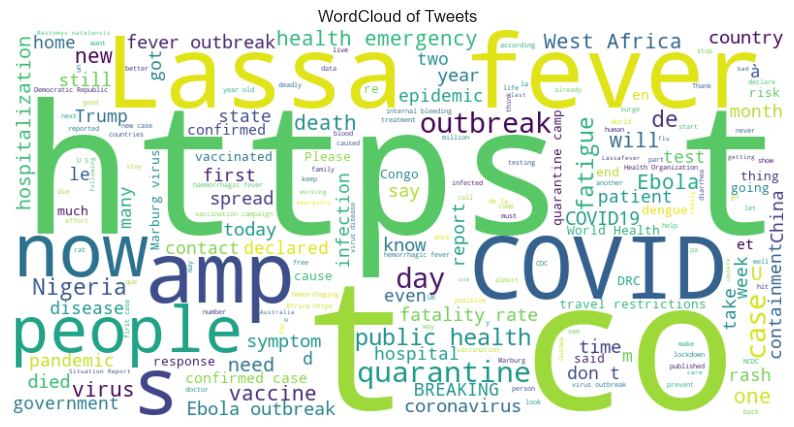

Top Keywords in News Articles: [('-', 185), ('Lassa', 112), ('in', 72), ('fever', 58), ('of', 55), ('and', 45), ('the', 42), ('Nature.com', 33), ('Fever', 30), ('virus', 29)]
Top Keywords in Tweets: [('the', 2673), ('to', 2006), ('of', 1809), ('in', 1607), ('a', 1487), ('and', 1390), ('is', 1178), ('for', 646), ('has', 573), ('on', 550)]


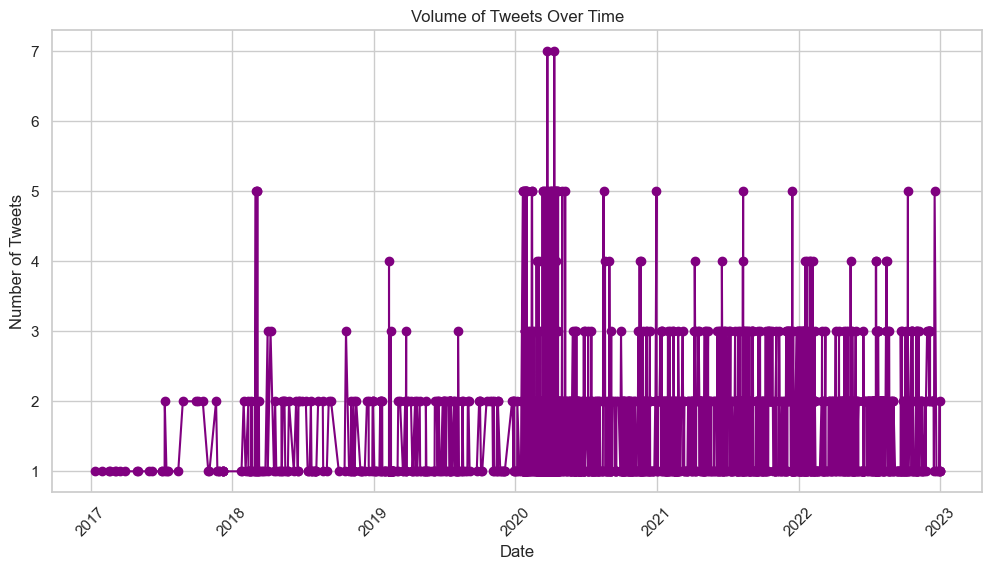

/var/folders/1g/022s0cxj6dqdlddrpjhcvwtc0000gn/T/ipykernel_22760/2439910678.py:44: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(combined_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)


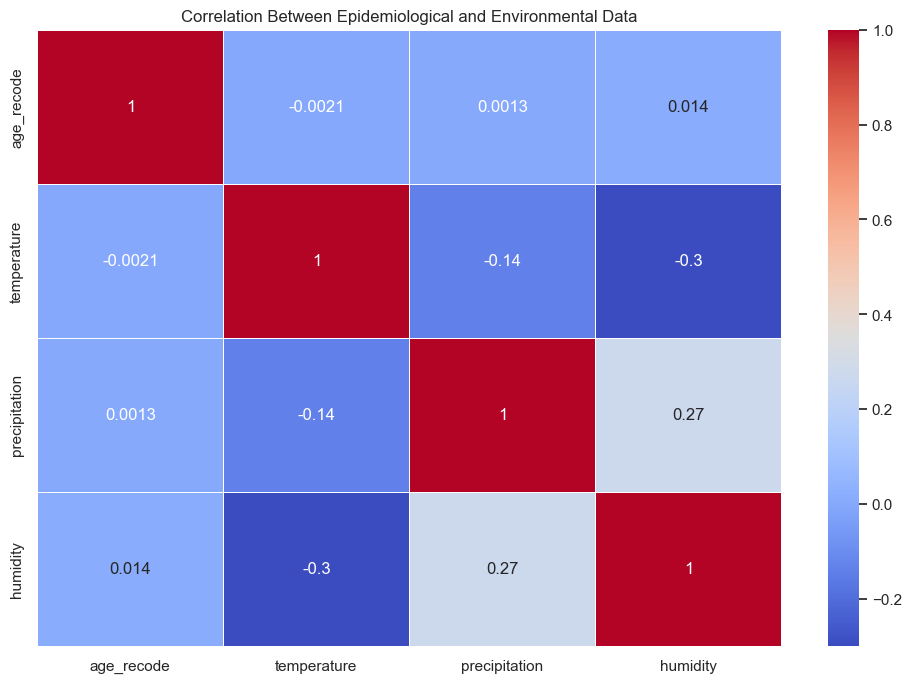

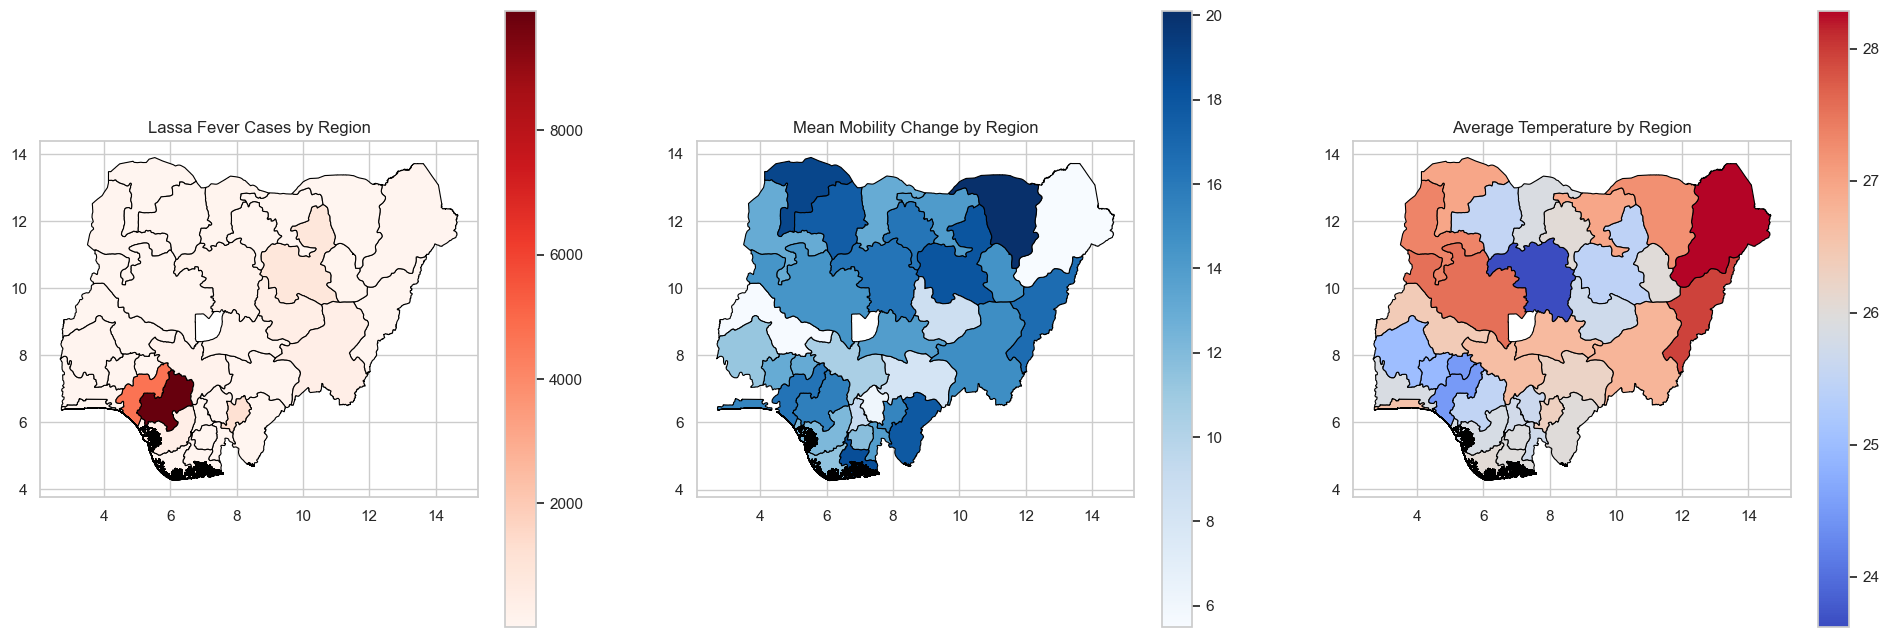

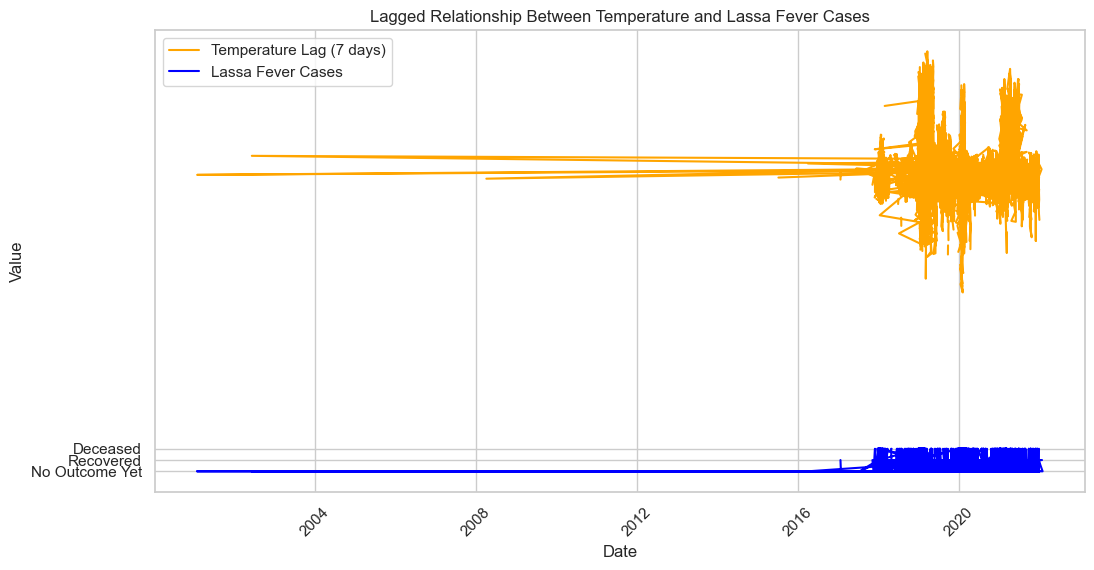

In [21]:
### --- Step 9: BERT Data Analysis (News and Tweets) ---

# WordCloud for News Articles
news_text = ' '.join(news_data['text'])
wordcloud_news = WordCloud(width=800, height=400, background_color='white').generate(news_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_news, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of News Articles')
plt.show()

# WordCloud for Tweets
tweets_text = ' '.join(tweets_data['text'])
wordcloud_tweets = WordCloud(width=800, height=400, background_color='white').generate(tweets_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_tweets, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Tweets')
plt.show()

# Top keywords in News and Tweets
news_keywords = Counter(" ".join(news_data['text']).split()).most_common(10)
tweets_keywords = Counter(" ".join(tweets_data['text']).split()).most_common(10)
print("Top Keywords in News Articles:", news_keywords)
print("Top Keywords in Tweets:", tweets_keywords)

# Time-Series Analysis of Tweet Volumes Over Time
tweets_time_series = tweets_data.groupby('date')['text'].count().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(tweets_time_series['date'], tweets_time_series['text'], marker='o', color='purple')
plt.title('Volume of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### --- Step 11: Cross-Dataset Correlation Analysis ---

# Correlation between epidemiological, environmental, and socio-economic factors
combined_data = lassa_fever_data[['age_recode', 'outcome_case']].join(climatic_data[['temperature', 'precipitation', 'humidity']])
plt.figure(figsize=(12, 8))
sns.heatmap(combined_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Epidemiological and Environmental Data')
plt.show()

### --- Step 10 (Extended): Cross-Layered Analysis (Combining Factors) ---

# Combine Lassa Fever, Mobility, and Climatic Data for regional analysis

# Merge Lassa Fever, mobility, and climatic data with the geographical shapefile
# Merge Lassa Fever data with the geographical shapefile
combined_geo = gdf_nigeria.merge(lassa_fever_geo[['state', 'outcome_case']], left_on='NAME_1', right_on='state', how='left')

# Merge Mobility data
combined_geo = combined_geo.merge(mobility_geo[['state', 'mean_mobility']], on='state', how='left')

# Merge Climate data
combined_geo = combined_geo.merge(climate_geo[['state', 'temperature']], on='state', how='left')

# Plot maps side by side to compare Lassa Fever cases, mobility, and temperature
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot Lassa Fever cases
combined_geo.plot(column='outcome_case', cmap='Reds', legend=True, ax=axes[0], edgecolor='black', linewidth=0.8)
axes[0].set_title('Lassa Fever Cases by Region')

# Plot Mobility changes
combined_geo.plot(column='mean_mobility', cmap='Blues', legend=True, ax=axes[1], edgecolor='black', linewidth=0.8)
axes[1].set_title('Mean Mobility Change by Region')

# Plot Average temperature
combined_geo.plot(column='temperature', cmap='coolwarm', legend=True, ax=axes[2], edgecolor='black', linewidth=0.8)
axes[2].set_title('Average Temperature by Region')

plt.show()


### --- Step 11 (Updated): Time-Lagged Correlation Analysis ---

# Shift the climatic variables (e.g., temperature) by 7 days to study lagged effects on Lassa Fever cases
lassa_fever_data['temp_lag_7'] = climatic_data['temperature'].shift(7)

# Plot the lagged relationship between temperature and Lassa Fever cases
plt.figure(figsize=(12, 6))
plt.plot(lassa_fever_data['date'], lassa_fever_data['temp_lag_7'], label='Temperature Lag (7 days)', color='orange')
plt.plot(lassa_fever_data['date'], lassa_fever_data['outcome_case'], label='Lassa Fever Cases', color='blue')
plt.title('Lagged Relationship Between Temperature and Lassa Fever Cases')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

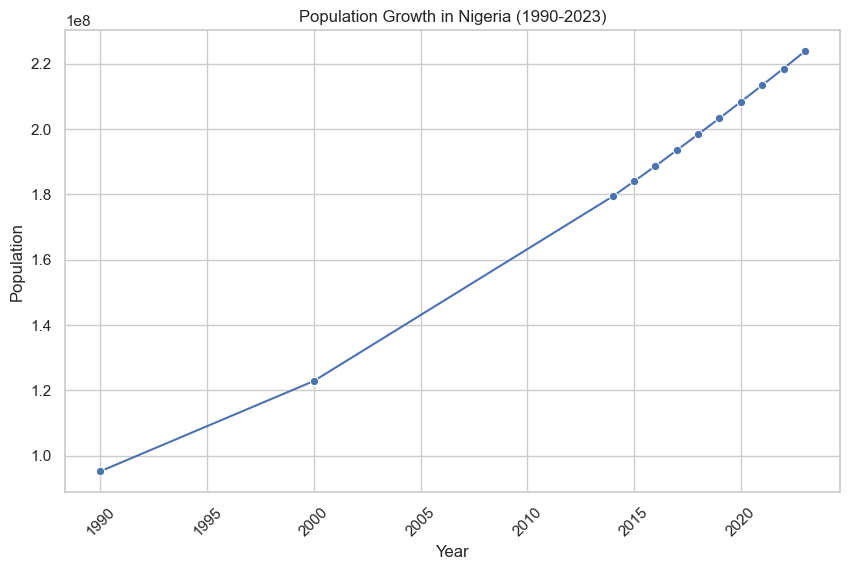

In [19]:
# Filter the dataset for Nigeria's total population data
population_nigeria = population_data[population_data['Country Name'] == 'Nigeria']
population_nigeria = population_nigeria[population_nigeria['Series Name'] == 'Population, total']

# Convert year columns to numeric if not done already
year_columns = ['1990 [YR1990]', '2000 [YR2000]', '2014 [YR2014]', '2015 [YR2015]', 
                '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', 
                '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]', '2023 [YR2023]']

# Convert all year columns to numeric, coerce any non-numeric values to NaN
for col in year_columns:
    population_nigeria[col] = pd.to_numeric(population_nigeria[col], errors='coerce')

# Reshape the data for plotting: create a year column and a population column
population_nigeria_melted = population_nigeria.melt(id_vars=['Country Name'], 
                                                   value_vars=year_columns,
                                                   var_name='Year', 
                                                   value_name='Population')

# Clean the 'Year' column to remove the '[YR]' part and convert to integers
population_nigeria_melted['Year'] = population_nigeria_melted['Year'].str.extract('(\d+)').astype(int)

# Plot the population trend over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=population_nigeria_melted, x='Year', y='Population', marker='o')
plt.title('Population Growth in Nigeria (1990-2023)')
plt.xlabel('Year')
plt.ylabel('Population')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

